<h1> Classification with Neural Networks: Keras vs "From Scratch"</h1>

In this notebook I will show how to use neural networks for classification tasks. We will use the famous iris data set. In particular, I will compare results from training a neural network with the Keras library and training the neural network we coded up from scratch in the previous notebook. For this purpose, I put the neural network code in the SCRIPTS folder: we will import it here as an external package.

<h2> Importing the data set </h2>

We will first have to import the dataset and create the design matrix $X$ and the target vector $y$. The target vector contain labels representing the different classes of our data set, so we have transform the target vector in a one-hot encoded matrix. Furthermore, we will split the data set in test and cross-validation sets: in this way we can train on a part of the data and test the accuracy on the cross-validation one.

In [1]:
# Add library path to system libraries
import sys
sys.path.append('../SCRIPTS/')
# Import library to load model and make predictions
import numpy as np
import pandas as pd
import random
import lib_nnet as libnn # custom neural network
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Read dataset in dataframe
df = pd.read_csv('../DATASETS/iris_dataset.csv',header=None).dropna()
print(df.head())

     0    1    2    3            4
0  5.1  3.5  1.4  0.2  Iris-setosa
1  4.9  3.0  1.4  0.2  Iris-setosa
2  4.7  3.2  1.3  0.2  Iris-setosa
3  4.6  3.1  1.5  0.2  Iris-setosa
4  5.0  3.6  1.4  0.2  Iris-setosa


In [3]:
# Design matrix and target vector
X = df.loc[:,:3].values
y = df.loc[:,4].values
# Scale design matrix (X) entries from 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(copy=True, feature_range=(0,1))
X = scaler.fit_transform(X)
# Encode target vector (y) with dummy variables (one-hot encoding)
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y = encoder.fit_transform(y)

In [4]:
# Function to shuffle data
def _shuffle(X,y):
    idx = np.arange(len(y))
    np.random.shuffle(idx)    
    return(X[idx,:], y[idx,:])
# Function to split data set into training and cross-validation (or test) data sets
# p_train is the percentage of the data set used as training (default is 80%)
def _split(X,y,p_train=0.8):
    idx = int(len(y) * p_train)
    Xtrain = X[:idx,:]
    ytrain = y[:idx,:]
    Xcv = X[idx:,:]
    ycv = y[idx:,:]
    return Xtrain, ytrain, Xcv, ycv

# Shuffle data randomly
np.random.seed(12365)
X,y = _shuffle(X,y)
# Split in training and cross validation sets
Xtrain, ytrain, Xcv, ycv = _split(X,y)

<h2> Training with Keras </h2>

Here we train a one hidden layer neural network with Keras. We want to benchmark our network implementation with the Keras implementation, so we will use similar settings: we will use momentum (not accelerated nesterov momentum), the learning rate will be constant (no decay), the loss function will be the mean squared error, we will use gradient descent for back-propagation, and the activation function will be the sigmoid.

In [5]:
# Get accuracy on a given dataset
def _test(nnet, X, y, verbose=False):
    ypred = [np.argmax(i) for i in nnet.predict(X, batch_size=1)]
    y = [np.argmax(i) for i in y]
    success = np.nansum([1 for i in range(len(y)) if y[i] == ypred[i]])
    if verbose:
        print("Accuracy on dataset: %5.2f %%" % (100*np.divide(success,len(ypred))))
    return 100*np.divide(success,len(ypred))

# Keras implementation
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

nnet = Sequential()
# Hidden layer
nnet.add(Dense(10, input_dim=X.shape[1], activation='sigmoid'))
# Output layer
nnet.add(Dense(3, activation='sigmoid'))
# Set optimizer parameters
sgd = SGD(decay=0.0, lr=0.1, nesterov=False, momentum=0.9)
# Compile and set the loss function
nnet.compile(loss="mean_squared_error", optimizer=sgd, metrics=['accuracy'])

# Train online for 10 epochs
nnet.fit(Xtrain,ytrain,epochs=10,shuffle=True, verbose=1, batch_size=1)
acc_train = _test(nnet, Xtrain, ytrain, verbose=True)
# Test on cross validation set
acc_cv = _test(nnet, Xcv, ycv, verbose=True)

Using TensorFlow backend.


Epoch 1/10
120/120 [==============================] - 0s - loss: 0.2297 - acc: 0.3833         
Epoch 2/10
120/120 [==============================] - 0s - loss: 0.1687 - acc: 0.6500         
Epoch 3/10
120/120 [==============================] - 0s - loss: 0.1274 - acc: 0.6917     
Epoch 4/10
120/120 [==============================] - 0s - loss: 0.1091 - acc: 0.7250     

Depending on the random initialization of the network weights and the shuffling of the data set, we might be lucky enough to obtain good accuracy both on the train and on the cross-validation data sets. However, we might want a more robust estimate of our accuracy. To do so we can perform bootstrapping: we train our model $K$ times, each time we initialize the nnet weights differently and we shuffle and split the data in a different way. The final accuracy would then be an average of the accuracies during the bootstrapping procedure. 

In [6]:
# Perform Bootstrapping
K = 20
acc_cv = []
acc_train = []
for k in range(K):
    # Shuffle data randomly
    X,y = _shuffle(X,y)
    # Split in training and cross validation sets
    Xtrain, ytrain, Xcv, ycv = _split(X,y,p_train=0.8)
    # Train model again
    nnet = Sequential()
    nnet.add(Dense(10, input_dim=X.shape[1], activation='sigmoid'))
    nnet.add(Dense(3, activation='sigmoid'))
    sgd = SGD(decay=0.0, lr=0.1, nesterov=False, momentum=0.9)
    nnet.compile(loss="mean_squared_error", optimizer=sgd, metrics=['accuracy'])
    # Train online for 10 epochs
    nnet.fit(Xtrain,ytrain,epochs=50,shuffle=True, verbose=0, batch_size=1)
    acc_train.append(_test(nnet, Xtrain, ytrain)) 
    acc_cv.append(_test(nnet, Xcv, ycv)) 
    print("%5.2f %% -- %5.2f %%" % (acc_train[k],acc_cv[k]))
print("\nMean accuracy on train: %5.2f %% +/- %5.2f %%" % (np.mean(acc_train),np.std(acc_train)))
print("Mean accuracy on cv: %5.2f %% +/- %5.2f %%" % (np.mean(acc_cv),np.std(acc_cv)))

98.33 % -- 96.67 %
96.67 % -- 96.67 %
97.50 % -- 96.67 %
92.50 % -- 90.00 %
96.67 % -- 96.67 %
95.83 % -- 100.00 %
96.67 % -- 96.67 %
96.67 % -- 96.67 %
95.83 % -- 93.33 %
96.67 % -- 96.67 %
97.50 % -- 100.00 %
98.33 % -- 100.00 %
97.50 % -- 100.00 %
94.17 % -- 93.33 %
95.83 % -- 100.00 %
95.00 % -- 96.67 %
92.50 % -- 96.67 %
97.50 % -- 96.67 %
95.00 % -- 93.33 %
95.00 % -- 100.00 %

Mean accuracy on train: 96.08 % +/-  1.63 %
Mean accuracy on cv: 96.83 % +/-  2.68 %


The accuracy on the train and cross-validation sets are similar, meaning we are not overfitting the network on the training data set.

<h2> Training our "from scratch" neural network </h2>

Here we repeat the above training, but with the neural network we have implemented from scratch using the same parameters we used for the Keras model. Hopefully we will get similar results!

In [7]:
# Set parameters
learning_rate = 0.1
n_epochs = 100
momentum = 0.9
n_hidden_nodes = 10

neural_net = libnn.network(n_input=Xtrain.shape[1], n_output=ytrain.shape[1], n_hidden=n_hidden_nodes)
cverror = neural_net.train(Xtrain, ytrain, xtest=Xcv, ytest=ycv, lrate = learning_rate,maxIter = n_epochs, opt = 'SGD', mom = momentum, 
                 verbose = False, reshuffle = True)

print("Accuracy on train set: %5.2f %%" % neural_net.getAccuracy(Xtrain,ytrain))
print("Accuracy on cv set: %5.2f %%" % neural_net.getAccuracy(Xcv,ycv))
print("Total loss: %f " % neural_net.getError(Xtrain,ytrain))

Accuracy on train set:  0.97 %
Accuracy on cv set:  1.00 %
Total loss: 0.038918 


We can further explore the behaviour of the network by plotting the error (cv and train) with respect to the training epoch:

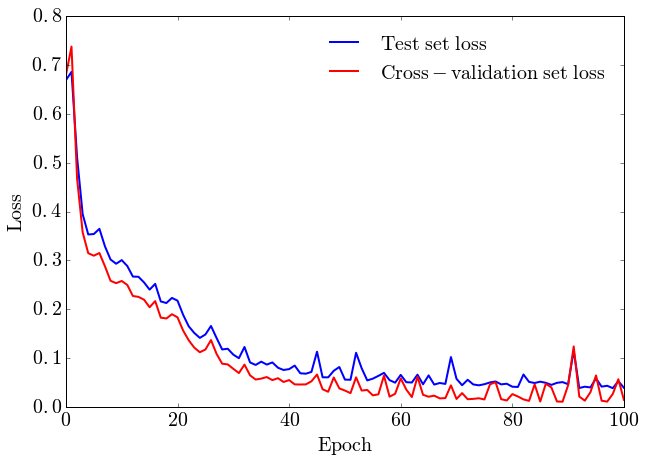

In [8]:
fig,ax = plt.subplots(figsize=(10,7))

ax.plot(np.arange(len(neural_net.error)),neural_net.error,lw=2.0,color='blue',label='$\\rm{Test\ set\ loss}$')
ax.plot(np.arange(len(cverror)),cverror,color='red',lw=2.0,label='$\\rm{Cross-validation\ set\ loss}$')
ax.set_xticklabels(['$'+str(int(i))+'$' for i in ax.get_xticks()],fontsize=20)
ax.set_yticklabels(['$'+str((i))+'$' for i in ax.get_yticks()],fontsize=20)
ax.set_xlabel("$\\rm{Epoch}$",fontsize=20)
ax.set_ylabel("$\\rm{Loss}$",fontsize=20)
ax.legend(loc='upper right', frameon=False, fontsize=20)
plt.show()

The loss for both the training and cross-validation sets decreases as we train the network for more and more epochs. The loss between the two sets is comparable, showing we are not overfitting to the training data set. We also observe some fluctuations in the loss, which are due to the re-shuffling of the training data set at each epoch: re-shuffling helps to avoid correlations between the data.

We can now perform bootstrapping to obtain a more robust estimate of the accuracy of our network.

In [9]:
# Set parameters
learning_rate = 0.1
n_epochs = 50
momentum = 0.9
n_hidden_nodes = 10
# Perform Bootstrapping
K = 20
acc_cv = []
acc_train = []
for k in range(K):
    # Shuffle data randomly
    X,y = _shuffle(X,y)
    # Split in training and cross validation sets
    Xtrain, ytrain, Xcv, ycv = _split(X,y,p_train=0.8)
    # Train model again
    neural_net = libnn.network(n_input=Xtrain.shape[1], n_output=ytrain.shape[1], n_hidden=n_hidden_nodes)
    neural_net.train(Xtrain, ytrain,lrate = learning_rate,maxIter = n_epochs, opt = 'SGD', mom = momentum, 
                 verbose = False, reshuffle = True)
    acc_train.append(neural_net.getAccuracy(Xtrain,ytrain)) 
    acc_cv.append(neural_net.getAccuracy(Xcv,ycv)) 
    print("%5.2f %% -- %5.2f %%" % (acc_train[k],acc_cv[k]))
print("\nMean accuracy on train: %5.2f %% +/- %5.2f %%" % (np.mean(acc_train),np.std(acc_train)))
print("Mean accuracy on cv: %5.2f %% +/- %5.2f %%" % (np.mean(acc_cv),np.std(acc_cv)))

 0.94 % --  0.97 %
 0.97 % --  0.97 %
 0.97 % --  1.00 %
 0.97 % --  1.00 %
 0.96 % --  1.00 %
 0.95 % --  1.00 %
 0.99 % --  0.93 %
 0.96 % --  0.93 %
 0.97 % --  0.93 %
 0.94 % --  0.90 %
 0.96 % --  0.97 %
 0.99 % --  0.97 %
 0.97 % --  0.93 %
 0.97 % --  0.93 %
 0.97 % --  0.97 %
 0.96 % --  1.00 %
 0.96 % --  0.93 %
 0.98 % --  0.97 %
 0.97 % --  0.97 %
 0.93 % --  0.93 %

Mean accuracy on train:  0.96 % +/-  0.02 %
Mean accuracy on cv:  0.96 % +/-  0.03 %


Accuracies on both training and cross-validation sets look good and similar, meaning we are not overfitting the network to the training data set. Also, the values are pretty similar to the ones obtained with Keras, which is definitely good news! 